Una vez balanceado el dataset en su varaible respuesta y por nacionalidades todavía tenemos un dataset de casi 80K casos. Se ha analizado cuál sería el tamaño optimo para modelizar.

Se han probado 3 modelos distintos con una minima restriccion de profundidad para los modelos basados en arboles. Vemos que el accuracy de los modelos aumenta aproximadamente hasta los 10.000 casos.

### Open File

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
df = pd.read_csv('./data/df_features.gz')

### Create Predicted Category for final models (2 categories)

In [3]:
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [4]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [5]:
category = np.array(['Bad' if i < 7 else 'Good' for i in df.Reviewer_Score])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df) 

Good    0.831599
Bad     0.168401
Name: Category, dtype: float64

### Balance Categories

In [6]:
def balance_df(df, Balance_Nationality, Balance_Category, cut):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = cut
            if len(nationality) < n:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [7]:
df_balanced_1 = balance_df(df, Balance_Nationality=False, Balance_Category=True, cut=10000)
df_balanced_2 = balance_df(df_balanced_1, Balance_Nationality=True, Balance_Category=True, 
                         cut=int(np.median(df_balanced_1.Nationality_Recode.value_counts())*1.5))
df_balanced_2.shape

(77270, 78)

### Prepare Data to run Models

In [8]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','Price','Reservation_ADR',
               'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
x_col = x_categorical + x_numerical
y_col = 'Category'

I standarize numerical features

In [9]:
X_numerical = df_balanced_2[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

Create 1/0 variables for the categorical features

In [10]:
X_categorical = pd.get_dummies(df_balanced_2[x_categorical], prefix_sep='_', drop_first = True)
X_categorical = X_categorical.fillna('Not Available')

In [11]:
X = pd.concat([X_numerical_std, X_categorical], axis = 1, sort = False)
y = df_balanced_2[y_col]

In [12]:
X.shape, y.shape

((77270, 69), (77270,))

## MODELS

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [45]:
from sklearn.model_selection import train_test_split
import random

n = 0
sizes = [500, 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000]
universe = list(X.index)
models = [DecisionTreeClassifier(max_depth=5, random_state=1), 
          LogisticRegression(max_iter=1000, random_state=1),
          RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state=1)]

acc_mean = []
for model in models:
    accuracies = []
    n_tries = 10
    for i in range(n_tries):
        tmp = []
        for size in sizes:
            random.seed(i)
            sample = random.sample(universe, size)
            X_size = X.loc[sample, :]
            y_size = y[sample]
            tmp.append(np.mean(cross_val_score(model, X_size, y_size, cv=10, scoring='accuracy')))
            n = n+1
            print(f'{(100*n)/(len(sizes)*len(models)*n_tries):.2f}', end='\r', flush=True)
        accuracies.append(tmp)
    acc_mean.append(np.mean(accuracies, axis=0)) 

<IPython.core.display.Javascript object>


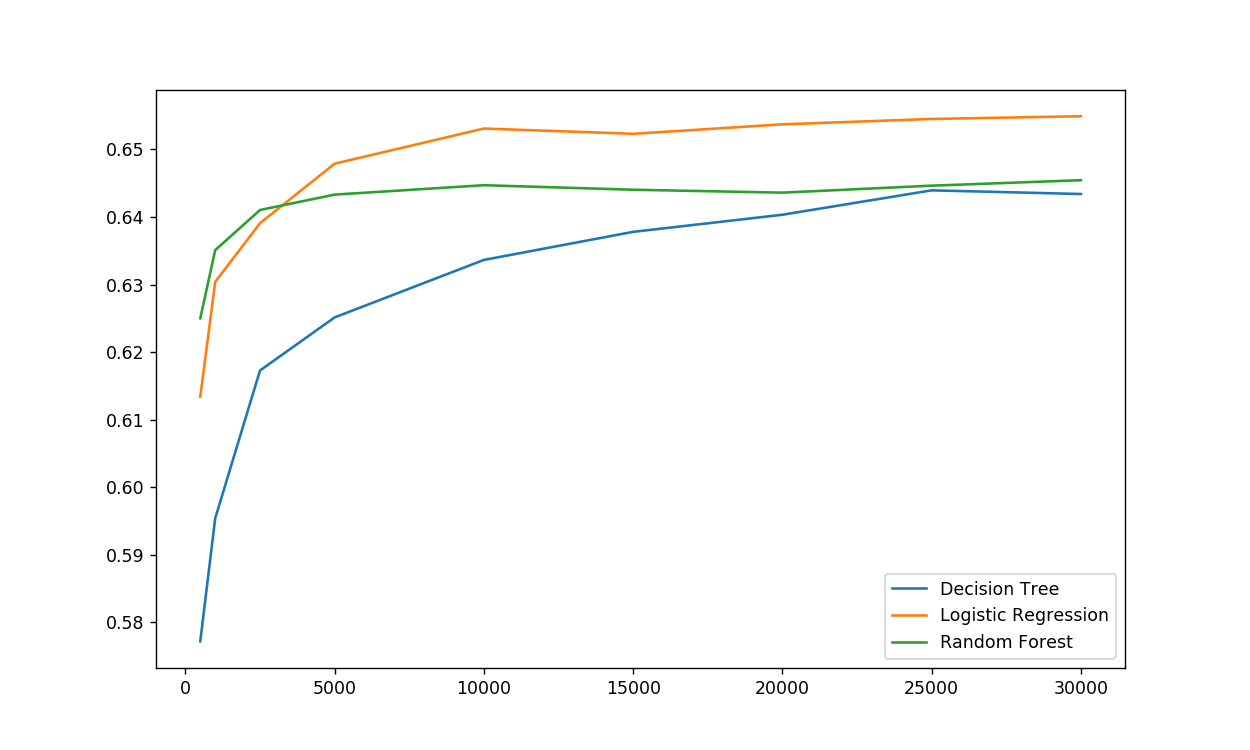

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sizes, acc_mean[0], label = 'Decision Tree')
ax.plot(sizes, acc_mean[1], label = 'Logistic Regression')
ax.plot(sizes, acc_mean[2], label = 'Random Forest')
ax.legend()

In [47]:
pd.DataFrame(acc_mean, columns = sizes, index=['DT','LR','RF'])

,500,1000,2500,5000,10000,15000,20000,25000,30000
DT,0.5772,0.5954,0.61728,0.62514,0.63365,0.637807,0.640340,0.643952,0.643407
LR,0.6134,0.6304,0.63908,0.64790,0.65310,0.652320,0.653725,0.654520,0.654920
RF,0.6250,0.6351,0.64104,0.64332,0.64471,0.644040,0.643610,0.644644,0.645453
